In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
# Read in dataset 1
data = pd.read_excel("dataset_1.xls")

# Data Cleaning

From the initial viewing of the data, we noticed that many instances had missing data for some dates (usually tdate10 through tdate12). For now, we have set those values to NaN. For the non-date values, we imputed values as the column's average.

We also noticed whitespace occurred in the columns. We erased them and lowercased the names for simplicity.

In [3]:
# Example of an instance without data for each date, shows column formatting as well
data.iloc[1,:]

State                          11
 Herd                           2
# PTAs                        319
 PTAM                         309
PTAF                           23
PTAP                           12
RHA # cows                    331
 % W PTAs                      97
 RHAM                       30020
 RHAF                        1134
 RHAP                         923
Tdate1        2018-08-27 00:00:00
 Milk1                         85
 Fat1                         3.6
 Pro1                           3
Tdate2        2018-07-17 00:00:00
 Milk2                         80
 Fat2                         3.7
 Pro2                         2.9
Tdate3        2018-06-14 00:00:00
 Milk3                         87
 Fat3                         3.7
 Pro3                         3.1
Tdate4        2018-05-15 00:00:00
 Milk4                         80
 Fat4                         3.9
 Pro4                         3.1
Tdate5        2018-03-22 00:00:00
 Milk5                         81
 Fat5         

In [4]:
# Remove whitespace from column names
data.columns = list(map(lambda x: x.strip().lower(), data.columns))

# Find values of '  .' and set to NaN, or impute mean
for col in data.columns:
    try:
        data[col][data[col] == '  .'] = np.nan
        data[col][data[col] == ' . '] = np.nan
        data[col][data[col].apply(lambda x: x == '    .')] = \
            (data[col][data[col].apply(lambda x: x != '    .')]).mean()
        if "date" not in col:
            data[col] = data[col].astype(float)
    except:
        continue

# Remove rows with missing rhap and rhaf values
data = data[~data.rhap.apply(lambda x: x == '   .')]
data = data[~data.rhaf.apply(lambda x: x == '   .')]

# Data Analysis

In [5]:
# Dimensions of data
data.shape

(7868, 59)

In [6]:
# Initial summary statistics
data.describe()

,state,herd,# ptas,ptam,ptaf,ptap,rha # cows,% w ptas,rham,milk1,...,pro9,milk10,fat10,pro10,milk11,fat11,pro11,milk12,fat12,pro12
count,7868.000000,7868.000000,7868.000000,7868.000000,7868.000000,7868.000000,7868.000000,7868.000000,7868.000000,7868.000000,...,6377.000000,5862.000000,5862.000000,5862.000000,5084.000000,5084.000000,5084.000000,3792.000000,3792.000000,3792.000000
mean,31.645018,3948.971022,142.494026,151.996187,9.072572,5.805923,214.635613,62.069268,22967.245933,61.246441,...,3.150902,62.032071,3.875384,3.140873,61.739772,3.805566,3.096755,62.259757,3.779562,3.064030
std,11.873456,2279.585578,355.704442,354.728682,12.943216,10.895686,440.014365,28.295911,4037.126645,12.274327,...,0.134823,11.677153,0.320749,0.137300,11.787988,0.313746,0.127782,11.521145,0.301008,0.122117
min,11.000000,1.000000,1.000000,-2940.000000,-108.000000,-99.000000,2.000000,0.000000,462.000000,2.000000,...,2.500000,15.000000,2.200000,2.500000,17.000000,2.400000,2.500000,15.000000,2.400000,2.500000
25%,23.000000,1976.750000,31.000000,-1.000000,3.000000,1.000000,60.000000,45.000000,20598.000000,54.000000,...,3.100000,55.000000,3.700000,3.100000,54.000000,3.600000,3.000000,55.000000,3.600000,3.000000
50%,31.000000,3947.500000,58.000000,213.000000,11.000000,7.000000,94.000000,71.000000,23328.000000,62.000000,...,3.100000,63.000000,3.900000,3.100000,62.000000,3.800000,3.100000,63.000000,3.800000,3.100000
75%,41.000000,5921.250000,117.000000,371.000000,17.000000,12.000000,186.000000,84.000000,25661.000000,70.000000,...,3.200000,70.000000,4.100000,3.200000,70.000000,4.000000,3.200000,70.000000,3.900000,3.100000
max,74.000000,7919.000000,9789.000000,1234.000000,63.000000,44.000000,9008.000000,250.000000,36275.000000,129.000000,...,3.700000,100.000000,6.600000,3.800000,102.000000,6.200000,3.700000,100.000000,5.900000,3.700000


In [7]:
# Amount of unique states the herds are from
len(data.state.unique())

38

In [8]:
# Amount of unique herds, since each row is a unique herd, should be the same amount - removed rows
len(data.herd.unique())

7868

Each herd had 6-12 observations of herd production taken at various dates in the past year. In evaluating these entries, we noticed several herds had very little variation in their total milk production over the year.

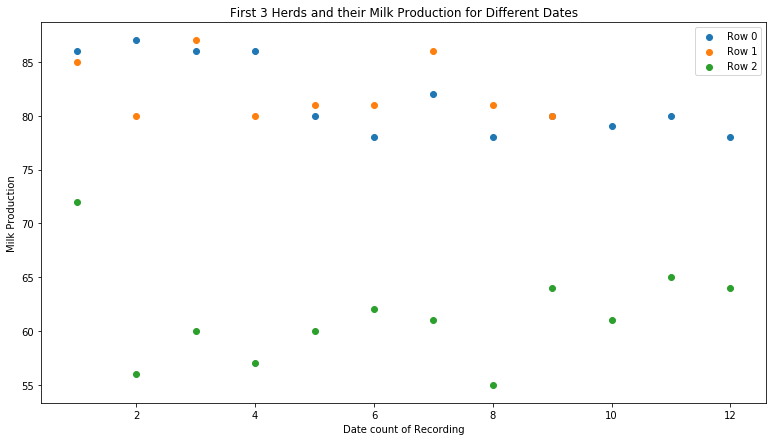

In [9]:
cowMilkList = [col for col in data if col.startswith('milk')]
cowMilk = data[cowMilkList]
plt.figure(figsize=(13,7))
for i in range(3):
    plt.scatter(range(1,13),cowMilk.iloc[i])
plt.xlabel("Date count of Recording")
plt.ylabel("Milk Production")
plt.title("First 3 Herds and their Milk Production for Different Dates")
plt.legend(["Row 0", "Row 1", "Row 2"]);

We wanted to investigate if the difference in production month-to-month was worth looking into, so for each output variable of milk, fat, and protein, we found the standard deviation of that variable for each herd individually, then took the average of the standard deviations for each output.

In [10]:
cowFatList = [col for col in data if col.startswith('fat')]
cowProList = [col for col in data if col.startswith('pro')]
cowMilkList = [col for col in data if col.startswith('milk')]

cowFat = data[cowFatList]
cowPro = data[cowProList]
cowMilk = data[cowMilkList]

sds = 0
count = 0
for lst in [cowFat,cowPro,cowMilk]:
    for i in range(lst.shape[0]):
        x = pd.Series(lst.iloc[[i]].values.tolist()[0]).describe()[2]
        add = 0 if np.isnan(x) else 1
        x = 0 if np.isnan(x) else x
        count += add
        sds += x
    print(sds/count)

0.21460056115809667
0.16108592713282582
1.7480361062898773


As we can see, the average standard deviation of each output variable was very low, especially in comparison to the actual raw values we see, so we decided that the month-to-moth difference in production was insignificant enough to be ignored, and as such could just take each herd's average as our expected output variable

# Model Creation

### Prepare training and test data

In [11]:
# Create functions for automation between subjects

def prepare_data(data, subject):
    subject_columns = []
    
    # For each column, test if the column pertains to the subject
    for col in data.columns:
        if subject in col:
            subject_columns.append(col)

    # Return the average along the row of all of the subject columns
    return data.loc[:, subject_columns].mean(axis=1, skipna=True)

def split_data(X, y, test_size=0.3):
    
    # Remove rows where the truth label is NA
    X_temp = X[~y.isna()]
    y_temp = y[~y.isna()]
    
    # Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(X_temp, y_temp, test_size=test_size)
    
    return X_train, X_test, y_train, y_test

In [12]:
# Prepare relevant columns
subjects = ["milk", "fat", "pro"]
feature_cols = ['# ptas', 'ptam', 'ptaf', 'ptap', 'rha # cows',
                '% w ptas', 'rham', 'rhaf', 'rhap']

# Dictionaries for each subject
y = {}
subject_splits = {}
cv_scores = {}
test_rr = {}
subject_coef = {}

# Training feature vectors
X = data.loc[:, feature_cols]

# Normalize feature vectors
X = X.apply(lambda x: (x - x.mean()) / x.std())

# Split data into train and test for each subject
for subject in subjects:
    y[subject] = prepare_data(data, subject)
    subject_splits[subject] = split_data(X, y[subject])

### Perform cross-validation to test values of alpha

In [13]:
for subject in subjects:
    # Keep track of cv scores for the current subject
    temp_scores = {}
    
    # For each alpha value, perform cross validation w/ Lasso and keep track of scores
    for a in range(0, 25):
        X_train, _, y_train, _ = subject_splits[subject]
        lasso = Lasso(alpha=a)
        temp_scores[a] = cross_val_score(lasso, X_train, y_train, cv=10).mean()
        
    # Store all scores in dictionary
    cv_scores[subject] = temp_scores

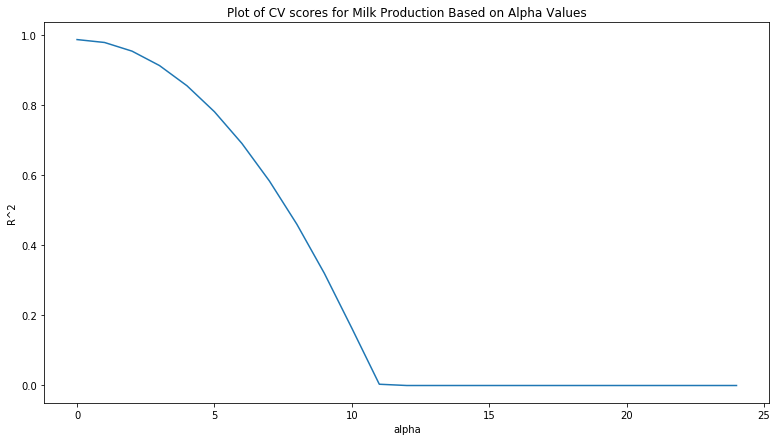

In [14]:
plt.figure(figsize=(13,7))
plt.plot(cv_scores["milk"].keys(), cv_scores["milk"].values())
plt.title("Plot of CV scores for Milk Production Based on Alpha Values")
plt.xlabel("alpha")
plt.ylabel("R^2");

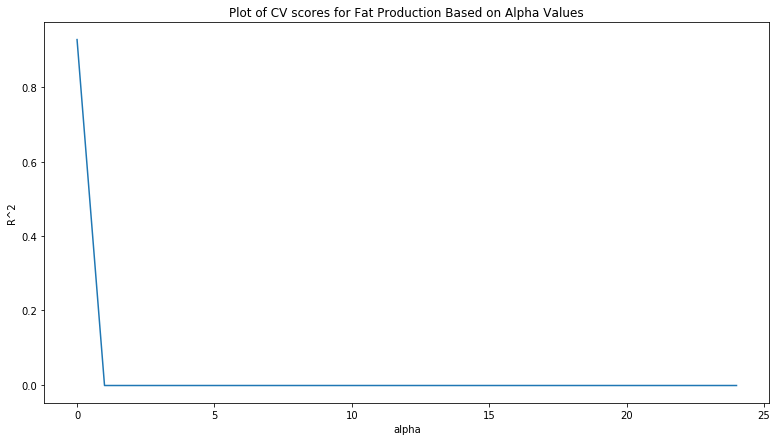

In [15]:
plt.figure(figsize=(13,7))
plt.plot(cv_scores["fat"].keys(), cv_scores["fat"].values())
plt.title("Plot of CV scores for Fat Production Based on Alpha Values")
plt.xlabel("alpha")
plt.ylabel("R^2");

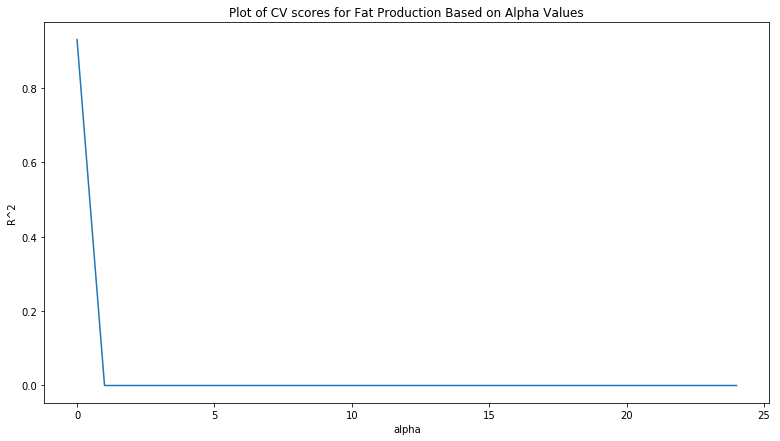

In [16]:
plt.figure(figsize=(13,7))
plt.plot(cv_scores["pro"].keys(), cv_scores["pro"].values())
plt.title("Plot of CV scores for Fat Production Based on Alpha Values")
plt.xlabel("alpha")
plt.ylabel("R^2");

As you can see, variations in alpha don't cause much difference in R^2 values for milk. For fat and protein, as alpha increase, our training accuracy decreases significantly. This is due to the over-complexity of the models for those large regularization values. Therefore, we will elect to have a less complex model with alpha = 0 (no regularization).

### Evaluate on test data

In [17]:
# For each subject, fit on train and predict on test
for subject in subjects:
    lasso = Lasso(alpha=0)
    X_train, X_test, y_train, y_test = subject_splits[subject]
    lasso.fit(X_train, y_train)
    
    # Store R^2 values in dictionary
    test_rr[subject] = lasso.score(X_test, y_test)
    
    # Store coeficients in dictionary
    subject_coef[subject] = lasso.coef_

test_rr

{'milk': 0.9892164229300431,
 'fat': 0.9483763257851938,
 'pro': 0.9296398942488598}

Test evaluation metrics seem really good. But we are still skeptical of the results. In future work, we will analyze the feature importances to determine what is playing the biggest role in the predictions.